In [247]:
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from up_down import get_up_down
from utils import get_sample_interval, load, save

# Notes from Github

_Switching Linear Dynamical Systems_ (SLDS) provide a natural way of combining Linear Dynamical Systems with Hidden Markov Models. They allow us to approximate a system that has globally non-linear dynamics by a series linear systems. A good reference for these types of systems is ["Variational Inference for State Space models"](https://www.cs.toronto.edu/~hinton/absps/switch.pdf) by Ghahramani and Hinton. 

An LDS comprises $K$ discrete hidden states, which evolve according to a Markov chain. We'll call the hidden state $z$, and use the notation $z_t = k$ to mean that the system is in state $k$ at time $t$. The Markov chain for the hidden state is specified by a state-transition matrix $Q$, where $Q_{ij} = P(z_t = j \mid z_{t-1} = i)$.

### Generative Model for SLDS
The generative model for an SLDS combines an HMM with a set of linear dynamical systems as follows. In addition to the discrete state, we have a continuous latent state $x_t \in \mathbb{R}^D$ and an observation $y_t \in \mathbb{R}^N$. Each discrete state $\{1,\ldots,K
\}$ is associated with a different dynamics matrix $A_k$ and a different measurement matrix $C_k$. Formally, we generate data from an SLDS as follows:

1. **Discrete State Update**. At each time step, sample a new discrete state $z_t \mid z_{t-1}$ with probabilities given by a Markov chain.

2. **Continuous State Update**. Update the state using the dynamics matrix corresponding to the new discrete state:
$$
x_t = A_k x_{t-1} + V_k u_{t} + b_k + w_t
$$
$A_k$ is the dynamics matrix corresponding to discrete state $k$. $u_t$ is the input vector (specified by the user, not inferred by SSM) and $V_k$ is the corresponding control matrix. The vector $b$ is an offset vector, which can drive the dynamics in a particular direction. 
The terms $w_t$ is a noise terms, which perturbs the dynamics. 
Most commonly these are modeled as zero-mean multivariate Gaussians,
but one nice feature of SSM is that it supports many distributions for these noise terms. See the Linear Dynamical Systems notebook for a list of supported dynamics models.

3. **Emission**. We now make an observation of the state, according to the specified observation model. In the general case, the state controlls the observation via a Generalized Linear Model:
$$
y_t \sim \mathcal{P}(\eta(C_k x_t + d_k + F_k u_t + v_t))
$$
$\mathcal{P}$ is a probabibility distribution. The inner arguments form an affine measurement of the state, which is then passed through the inverse link function $\eta(\cdot)$.
In this case, $C_k$ is the measurement matrix corresponding to discrete state $k$, $d_k$ is an offset or bias term corresponding to discrete state $k$, $F_k$ is called the feedthrough matrix or passthrough matrix (it passes the input directly to the emission). In the Gaussian case, the emission can simply be written as $y_t = C_k x_t + d_k + F_k u_t + v_t$ where $v_t$ is a Gaussian r.v. See the Linear Dynamical System notebook for a list of the observation models supported by SSM.

# Start with the Lorenz Series

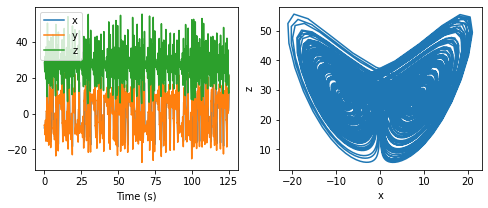

In [2]:
# ======================
# SIGNAL PARAMETERS
# ======================

T = 125 # s, duration of time series
dt = 0.02 # s, time step

initial_condition = (-8.01304744, -6.58865759, 28.60202532)

lorenz_pts = simulate_lorenz(dt=dt, T=T, initial_condition=initial_condition)

time_vals = np.arange(len(lorenz_pts))*dt
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')

plt.show()

In [3]:
data = lorenz_pts

In [4]:
# Set the parameters of the SLDS
time_bins = data.shape[0]    # number of time bins
n_disc_states = 1       # number of discrete states
latent_dim = 2       # number of latent dimensions
emissions_dim = 3      # number of observed dimensions

In [5]:
print("Fitting SLDS with Laplace-EM")

# Create the model and initialize its parameters
slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog")

# Fit the model using Laplace-EM with a structured variational posterior
q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=100, alpha=0.0)

# # Get the posterior mean of the continuous states
# q_lem_x = q_lem.mean_continuous_states[0]

# # Find the permutation that matches the true and inferred states
# slds.permute(find_permutation(states_z, slds.most_likely_states(q_lem_x, data)))
# q_lem_z = slds.most_likely_states(q_lem_x, data)

# # Smooth the data under the variational posterior
# q_lem_y = slds.smooth(q_lem_x, data)

Fitting SLDS with Laplace-EM


Initializing with an ARHMM using 25 steps of EM.


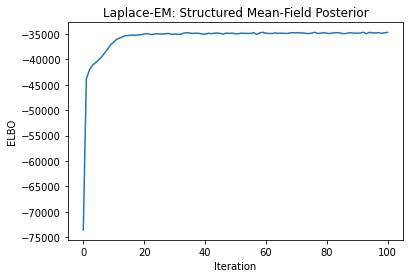

In [65]:
plt.plot(q_lem_elbos)
plt.title("Laplace-EM: Structured Mean-Field Posterior")
plt.ylabel('ELBO')
plt.xlabel("Iteration")
plt.show()

In [37]:
print(f"Eigenvalues of the transition matrix: {np.abs(np.real(np.linalg.eig(slds.dynamics._As)[0]))}")

Eigenvalues of the transition matrix: [[0.98575311 0.98575311]]


# Neural Data

## Load Data

In [5]:
filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
f = h5py.File(filename, 'r')
electrode_info, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = get_sample_interval(f, units='s')
lfp = f['lfp']
T = lfp.shape[1]

## Up and Down States

In [6]:
area_spike_dict = {}
for area in session_info['areas']:
    print(area)
    unit_inds = np.where(unit_info['area'] == area)[0]
    area_spike_dict[area] = np.zeros((len(unit_inds), T))
    for i, ind in enumerate(unit_inds):
        unit_spike_times = spike_times[ind][0, :]
        for t in unit_spike_times:
            area_spike_dict[area][i, int(t/dt)] = 1

vlPFC
FEF
CPB
7b


In [7]:
up_down_dict = get_up_down(area_spike_dict)

## Grab Signal and Plot

In [263]:
# ======================
# SIGNAL PARAMETERS
# ======================

# areas = ['vlPFC']
areas = np.unique(electrode_info['area'])
unit_indices = np.arange(lfp.shape[0])[pd.Series(electrode_info['area']).isin(areas)]
# trajectory_start_times = np.arange(0, 7001, 500) # s
start_time = 4500 # s
duration = 10 # s
gaussian_normalize = False

# ------------------
# get signal
# ------------------
start_step = int(start_time/dt)
length = int(duration/dt)
data = f['lfp'][unit_indices, start_step:start_step + length].T

if gaussian_normalize:
# normalize (gaussian normalization)
    for i in range(lfp_pts.shape[1]):
        lfp_pts[:, i] = (lfp_pts[:, i] - np.mean(lfp_pts[:, i]))/np.std(lfp_pts[:, i])
    
var_names = [f"unit_{unit_num} {electrode_info['area'][unit_num]}" for unit_num in unit_indices]
time_vals = np.arange(start_time, start_time+duration, dt)

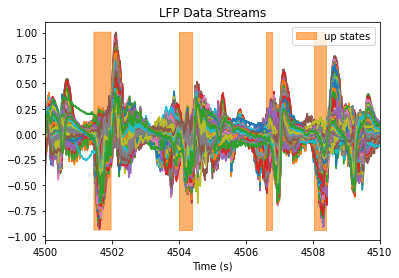

In [264]:
start = start_time
end = start_time + duration
def correct_ylim(ax, x, y):   
    # ax: axes object handle
    #  x: data for entire x-axes
    #  y: data for entire y-axes
    # assumption: you have already set the x-limit as desired
    lims = ax.get_xlim()
    i = np.where( (x > lims[0]) &  (x < lims[1]) )[0]
    ax.set_ylim( y[i].min(), y[i].max() ) 

for i in range(data.shape[1]):
#     plt.plot(time_vals, data[:, i], label=var_names[i])
    plt.plot(time_vals, data[:, i])
plt.xlabel('Time (s)')
plt.title(("Normalized " if gaussian_normalize else "") + "LFP Data Streams")
ax = plt.gca()
ax.fill_between(np.arange(len(up_down_dict[area]))*dt, data.min(), data.max(), where=up_down_dict[area], color='C1', alpha=0.6, label='up states')
ax.set_xlim([start, end])
plt.legend()

plt.show()

## Run SLDS

In [266]:
# Set the parameters of the SLDS
time_bins = data.shape[0]    # number of time bins
n_disc_states = 2      # number of discrete states
latent_dim = 2 # number of latent dimensions
emissions_dim = data.shape[1]      # number of observed dimensions

In [267]:
%%time
print("Fitting SLDS with Laplace-EM")
print(f"n_disc_states = {n_disc_states}, latent_dim = {latent_dim}")
# Create the model and initialize its parameters
slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog")

# Fit the model using Laplace-EM with a structured variational posterior
q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=10, alpha=0.0)

Fitting SLDS with Laplace-EM
n_disc_states = 2, latent_dim = 2


Initializing with an ARHMM using 25 steps of EM.



CPU times: user 3min 10s, sys: 5.75 s, total: 3min 16s
Wall time: 40.3 s


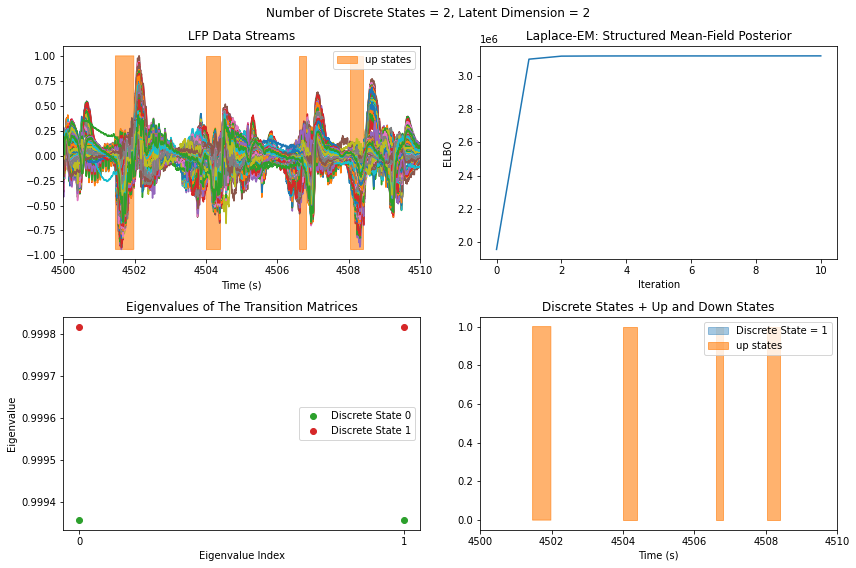

In [268]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
start = start_time
end = start_time + duration
def correct_ylim(ax, x, y):   
    # ax: axes object handle
    #  x: data for entire x-axes
    #  y: data for entire y-axes
    # assumption: you have already set the x-limit as desired
    lims = ax.get_xlim()
    i = np.where( (x > lims[0]) &  (x < lims[1]) )[0]
    ax.set_ylim( y[i].min(), y[i].max() ) 

for i in range(data.shape[1]):
#     plt.plot(time_vals, data[:, i], label=var_names[i])
    plt.plot(time_vals, data[:, i])
plt.xlabel('Time (s)')
plt.title(("Normalized " if gaussian_normalize else "") + "LFP Data Streams")
ax = plt.gca()
ax.fill_between(np.arange(len(up_down_dict[area]))*dt, data.min(), data.max(), where=up_down_dict[area], color='C1', alpha=0.6, label='up states')
ax.set_xlim([start, end])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(q_lem_elbos)
plt.title("Laplace-EM: Structured Mean-Field Posterior")
plt.ylabel('ELBO')
plt.xlabel("Iteration")
plt.subplot(2, 2, 3)
eigs = np.zeros((n_disc_states, latent_dim))
for i in range(n_disc_states):
    eigs[i] = np.abs(np.real(np.linalg.eig(slds.dynamics._As[i])[0]))
    eigs[i].sort()
    eigs[i] = eigs[i][::-1]

    plt.scatter(np.arange(latent_dim), eigs[i], label=f"Discrete State {i}", c=f'C{i+2}')
plt.xlabel("Eigenvalue Index")
plt.xticks(np.arange(latent_dim), np.arange(latent_dim))
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of The Transition Matrices")
plt.legend()

plt.subplot(2, 2, 4)
ax = plt.gca()
# Get the posterior mean of the continuous states
q_lem_x = q_lem.mean_continuous_states[0]
disc_states = slds.most_likely_states(q_lem_x, data)
ax.fill_between(time_vals, 0, 1, where=disc_states, label='Discrete State = 1', color='C0', alpha=0.4)
plt.title("Discrete States + Up and Down States")
ax.fill_between(np.arange(len(up_down_dict[area]))*dt, 0, 1, where=up_down_dict[area], color='C1', alpha=0.6, label='up states')
ax.set_xlim([start, end])
plt.xlabel("Time (s)")
plt.legend()

plt.suptitle(f"Number of Discrete States = {n_disc_states}, Latent Dimension = {latent_dim}")
plt.tight_layout()
plt.show()

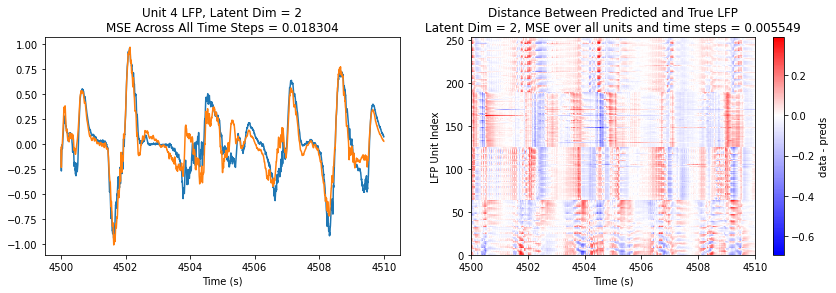

In [269]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
preds = slds.smooth(q_lem.mean_continuous_states[0], data)
i = 4
plt.plot(time_vals, data[:,i], c='C0', label='true LFP')
plt.plot(time_vals, preds[:,i], c='C1', label='predicted LFP')
# plt.legend()
plt.title(f"Unit {i} LFP, Latent Dim = {latent_dim}\nMSE Across All Time Steps = {((preds[:, i] - data[:, i])**2).mean():.6f}")
plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
diff = (data - preds).T
divnorm=colors.TwoSlopeNorm(vmin=diff.min(), vcenter=0., vmax=diff.max())
plt.pcolormesh(diff, cmap='bwr', norm=divnorm)
xtick_locs = plt.xticks()[0]
plt.xticks(xtick_locs, [int(val) for val in xtick_locs*dt + start_time])
plt.colorbar(label="data - preds")
plt.title(f"Distance Between Predicted and True LFP\nLatent Dim = {latent_dim}, MSE over all units and time steps = {((preds - data)**2).mean():.6f}")
plt.xlabel("Time (s)")
plt.ylabel("LFP Unit Index")

plt.show()

In [71]:
# (slds.emissions.Cs[0] @ q_lem.mean_continuous_states[0].T) + np.transpose([slds.emissions.ds[0]]*time_bins)

# Big Run

In [270]:
# areas = ['vlPFC']
areas = np.unique(electrode_info['area'])
unit_indices = np.arange(lfp.shape[0])[pd.Series(electrode_info['area']).isin(areas)]
stride = 0.1 # s
duration = 10 # s
start_times = np.arange(0, lfp.shape[1]*dt - duration + 0.1, int(stride/dt)).astype(np.int)


results = []
for start_time in tqdm(start_times):
    # ------------------
    # get signal
    # ------------------
    start_step = int(start_time/dt)
    length = int(duration/dt)
    data = f['lfp'][unit_indices, start_step:start_step + length].T
    var_names = [f"unit_{unit_num} {electrode_info['area'][unit_num]}" for unit_num in unit_indices]
    time_vals = np.arange(start_time, start_time+duration, dt)
    
    # Create the model and initialize its parameters
    slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog", verbose=False)

    # Fit the model using Laplace-EM with a structured variational posterior
    q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                                   variational_posterior="structured_meanfield",
                                   num_iters=10, alpha=0.0, verbose=False)
    
    eigs = np.zeros((n_disc_states, latent_dim))
    for i in range(n_disc_states):
        eigs[i] = np.abs(np.real(np.linalg.eig(slds.dynamics._As[i])[0]))
        eigs[i].sort()
        eigs[i] = eigs[i][::-1]
    
    preds = slds.smooth(q_lem.mean_continuous_states[0], data)
    mse = ((preds - data)**2).mean()
    
    
    results.append(dict(
        start_time=start_time,
        duration=duration,
        start_step=start_step,
        length=length,
        unit_indices=unit_indices,
        area=area,
        slds=slds,
        q_lem_elbos=q_lem_elbos,
        q_lem=q_lem,
        eigs=eigs,
        mse=mse
    ))

In [271]:
save(results, "../../__data__/slds/slds_big_run_full_brain")

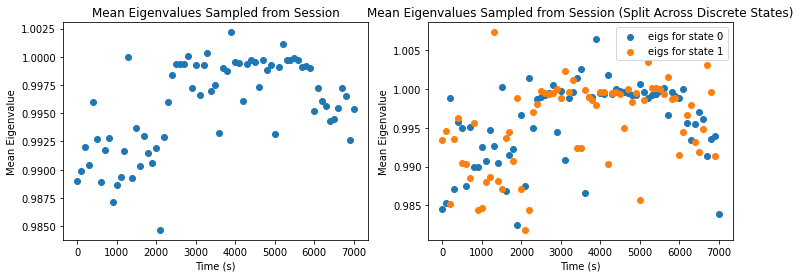

In [277]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
mean_eigs = np.array([results[i]['eigs'].mean() for i in range(len(results))])
plt.scatter(start_times, mean_eigs)
plt.xlabel('Time (s)')
plt.ylabel('Mean Eigenvalue')
plt.title("Mean Eigenvalues Sampled from Session")

plt.subplot(1, 2, 2)
mean_eigs = np.array([results[i]['eigs'].mean(axis=1) for i in range(len(results))])
for i in range(n_disc_states):
    plt.scatter(start_times, mean_eigs[:, i], label=f'eigs for state {i}')
plt.xlabel('Time (s)')
plt.ylabel('Mean Eigenvalue')
plt.title("Mean Eigenvalues Sampled from Session (Split Across Discrete States)")
plt.legend()
plt.show()

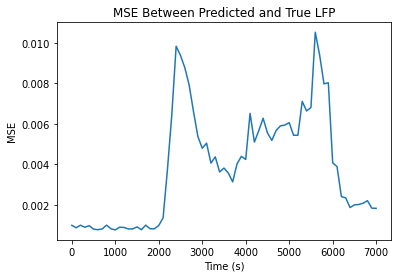

In [275]:
mse = np.array([results[i]['mse'] for i in range(len(results))])
plt.plot(start_times, mse)
plt.xlabel('Time (s)')
plt.ylabel('MSE')
plt.title("MSE Between Predicted and True LFP")
plt.show()